In [ ]:
# from google.colab import drive 
# drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [25]:
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, plot_confusion_matrix, roc_curve, auc, confusion_matrix, accuracy_score
from seaborn import heatmap

def plot_roc_curve(y_true, y_probas, title='ROC Curves',
                   plot_micro=True, plot_macro=True, classes_to_plot=None,
                   ax=None, figsize=None, cmap='nipy_spectral',
                   title_fontsize="large", text_fontsize="medium"):
    y_true = np.array(y_true)
    y_probas = np.array(y_probas)

    classes = np.unique(y_true)
    probas = y_probas

    if classes_to_plot is None:
        classes_to_plot = classes

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    ax.set_title(title, fontsize=title_fontsize)

    fpr_dict = dict()
    tpr_dict = dict()

    indices_to_plot = np.in1d(classes, classes_to_plot)
    for i, to_plot in enumerate(indices_to_plot):
        fpr_dict[i], tpr_dict[i], _ = roc_curve(y_true, probas[:, i],
                                                pos_label=classes[i])
        if to_plot:
            roc_auc = auc(fpr_dict[i], tpr_dict[i])
            color = plt.cm.get_cmap(cmap)(float(i) / len(classes))
            ax.plot(fpr_dict[i], tpr_dict[i], lw=2, color=color,
                    label='ROC curve of class {0} (area = {1:0.2f})'
                          ''.format(classes[i], roc_auc))
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=text_fontsize)
    ax.set_ylabel('True Positive Rate', fontsize=text_fontsize)
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc='lower right', fontsize=text_fontsize)
    return ax

def classify(m, X, y):
  y_pred = []
  y_prob = []
  for i in range(len(y)):
    X_test = X[i, :].reshape(1, -1)
    X_train = np.delete(X, i, axis=0)
    y_test = y[i]
    y_train = np.delete(y, i)
    m.fit(X_train, y_train)
    y_pred.append(m.predict(X_test))
    y_prob.append(m.predict_proba(X_test))
  y_prob = np.squeeze(y_prob)
  y_pred = np.squeeze(y_pred)
  return y_prob, y_pred

def plot_model(m, X, y, labels):
  y_prob, y_pred = classify(m, X, y)
  print('Accuracy score: ' + str(accuracy_score(y, y_pred)))
  heatmap(confusion_matrix(y, y_pred), annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.show()
  heatmap(confusion_matrix(y, y_pred, normalize='true'), annot=True, cmap=plt.cm.Blues, xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.show()
  plot_roc_curve(y, y_prob, plot_macro='False', plot_micro='False')
  plt.show()
  return y_prob, y_pred

In [26]:
import os
import pandas as pd

root = '../'
df = pd.read_csv(os.path.join(root, 'Database completo .csv'), header=0, index_col=0, delimiter=';')
result = pd.read_csv(os.path.join(root, 'miei_result.csv'), header=0, index_col=0)
df = df.loc[result.index.values]

df[df.columns[-1]].value_counts()

MCI        130
DEMENZA     62
NORMALI     30
MCI          1
Name: DGN1, dtype: int64

In [27]:
from sklearn.model_selection import LeaveOneOut, GridSearchCV, train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import numpy as np

def label(s):
    if s == 'NORMALI':
        return 0
    if s == 'MCI':
        return 1
    if s == 'DEMENZA':
        return 2

y = df.iloc[:,-1].to_numpy().astype(str)
unique = np.unique(y)
mapping = {}
for i in range(len(unique)):
     mapping[i] = np.where(y == unique[i])[0]
for idx in mapping[2]:
    y[idx] = unique[1]

y_3 = np.array(list(map(label, y)))
print(y_3)


[1 1 2 2 0 2 2 2 2 1 1 1 1 1 0 1 0 0 1 1 1 2 1 1 2 1 1 2 1 0 2 2 2 1 1 1 1
 1 1 0 0 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1
 0 1 1 1 1 2 1 2 2 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 2 1 2 1 1 1 0 1 0
 1 2 1 1 0 0 1 1 0 1 2 0 2 2 1 1 1 1 1 2 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1
 0 2 1 1 1 1 1 2 1 2 2 2 2 2 2 2 1 2 2 2 2 1 1 1 2 2 2 2 2 1 1 2 1 1 2 1 1
 1 1 2 1 2 2 1 1 2 0 1 1 1 1 2 2 2 2 2 2 2 2 1 2 1 2 1 2 1 1 1 2 1 2 1 2 1
 0]


In [28]:
X = result.to_numpy()
scaler_norm_pat = StandardScaler().fit(X)
X_s = scaler_norm_pat.transform(X)
print(X.shape)

y_norm_pat = np.array([0 if s==0 else 1 for s in y_3])
print(y_norm_pat)


(223, 18)
[1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 0 0 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0
 1 1 1 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0]


In [29]:

param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000],
      'coef0': np.linspace(-10, 10, 5),
      'degree': [2, 3, 4]}
svm_poly = GridSearchCV(SVC(kernel='poly', class_weight='balanced', probability=True, random_state=0), param_grid,
                        cv=LeaveOneOut(), refit=True, n_jobs=-1, verbose=1)
svm_poly.fit(X_s, y_norm_pat)

names = ['poly']
for m in [svm_poly]:
  m_best = m.best_estimator_
  print('LOOCV score = {}'.format(m.best_score_))
  print('model : {}'.format(m_best))
  #plot_model(m_best, X_s, y_norm_pat, ['NORMAL', 'PATHOLOGICAL'])

m_norm_pat = svm_poly.best_estimator_

Fitting 223 folds for each of 90 candidates, totalling 20070 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 2976 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 5776 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 9376 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 13776 tasks      | elapsed:   47.1s
[Parallel(n_jobs=-1)]: Done 18976 tasks      | elapsed:  1.1min


LOOCV score = 0.820627802690583
model : SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
    verbose=False)


[Parallel(n_jobs=-1)]: Done 20070 out of 20070 | elapsed:  1.2min finished


In [7]:
import joblib
joblib.dump(m_norm_pat, '../new_models/svm_model_normal_to_pathology.joblib')
joblib.dump(scaler_norm_pat, '../new_models/svm_scaler_normal_to_pathology.joblib')

['../new_models/svm_scaler_normal_to_pathology.joblib']

In [30]:
idx_2 = np.where(y_3 != 0)[0]
X_mci_dem = X[idx_2]
scaler_mci_dem = StandardScaler().fit(X_mci_dem)
X_s_mci_dem = scaler_mci_dem.transform(X_mci_dem)
y_mci_dem = y_3[idx_2] - 1
print(np.bincount(y_mci_dem))

[131  62]


In [31]:
X_mci_dem

array([[3, 1, 3, ..., 3, 3, 3],
       [3, 1, 3, ..., 3, 3, 3],
       [1, 1, 1, ..., 3, 3, 1],
       ...,
       [1, 1, 1, ..., 2, 1, 1],
       [1, 0, 1, ..., 0, 3, 0],
       [1, 3, 1, ..., 2, 1, 1]], dtype=int64)

In [32]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000],
      'coef0': np.linspace(-10, 10, 5),
      'degree': [2, 3, 4]}
svm_poly = GridSearchCV(SVC(kernel='poly', class_weight='balanced', probability=True, random_state=0), param_grid,
                        cv=LeaveOneOut(), refit=True, n_jobs=-1, verbose=1)
svm_poly.fit(X_s_mci_dem, y_mci_dem)

for m in [svm_poly]:
  m_best = m.best_estimator_
  print('LOOCV score = {}'.format(m.best_score_))
  print('model : {}'.format(m_best))
  #plot_model(m_best, X_s_mci_dem, y_mci_dem, ['MCI', 'DEMENTIA'])

m_MCI_dem = svm_poly.best_estimator_

Fitting 193 folds for each of 90 candidates, totalling 17370 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 6000 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 9600 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 12544 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done 16328 tasks      | elapsed:  1.2min


LOOCV score = 1.0
model : SVC(C=0.01, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=2, gamma='scale',
    kernel='poly', max_iter=-1, probability=True, random_state=0,
    shrinking=True, tol=0.001, verbose=False)


[Parallel(n_jobs=-1)]: Done 17355 out of 17370 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 17370 out of 17370 | elapsed:  1.4min finished


In [11]:

joblib.dump(m_MCI_dem, '../new_models/svm_model_MCI_to_dementia.joblib')
joblib.dump(scaler_mci_dem, '../new_models/svm_scaler_MCI_to_dementia.joblib')

['../new_models/svm_scaler_MCI_to_dementia.joblib']

In [23]:
from sklearn.calibration import CalibratedClassifierCV
clf = CalibratedClassifierCV(m_MCI_dem)
clf.fit(X_s_mci_dem, y_mci_dem)
test_score = scaler_mci_dem.transform([[3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 0, 3, 3, 3, 3, 2, 1, 2]])
proba = clf.predict_proba(test_score)

In [21]:
proba

array([[0.73190512, 0.26809488]])

In [36]:
test_score = scaler_mci_dem.transform([[3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 0, 3, 3, 3, 3, 2, 1, 2]])
m_MCI_dem.predict(test_score)

array([1])

Accuracy score: 0.820627802690583


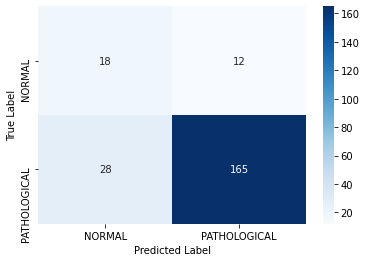

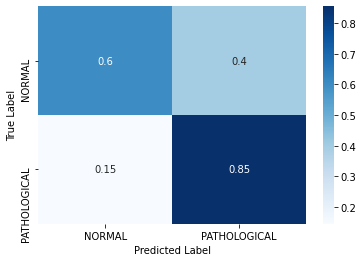

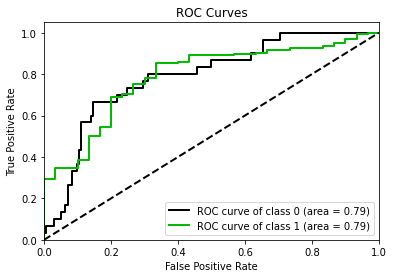

Accuracy score: 1.0


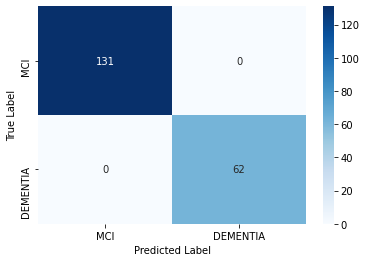

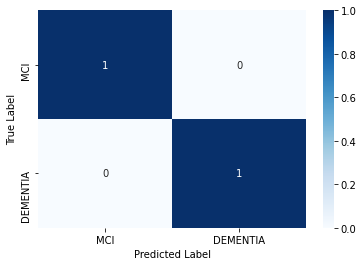

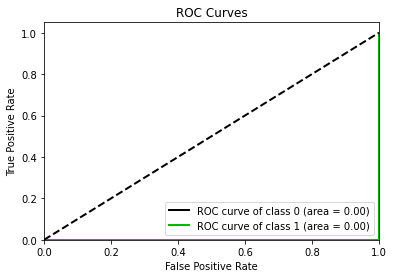

In [ ]:
y_prob_norm_pat, y_pred1 = plot_model(m_norm_pat, X_s, y_norm_pat, ['NORMAL', 'PATHOLOGICAL'])
y_prob_MCI_dem, y_pred2 = plot_model(m_MCI_dem, X_s_mci_dem, y_mci_dem, ['MCI', 'DEMENTIA'])


In [ ]:
print(y_3)
print(y_pred1)
print(y_pred2+1)
print(y_3.shape)
print(y_pred1.shape)
print(y_pred2.shape)
patologici = np.where(y_pred1 == 1)[0]
print(idx_2)
print(patologici)

[1 1 2 2 0 2 2 2 2 1 1 1 1 1 0 1 0 0 1 1 1 2 1 1 2 1 1 2 1 0 2 2 2 1 1 1 1
 1 1 0 0 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1
 0 1 1 1 1 2 1 2 2 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 2 1 2 1 1 1 0 1 0
 1 2 1 1 0 0 1 1 0 1 2 0 2 2 1 1 1 1 1 2 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1
 0 2 1 1 1 1 1 2 1 2 2 2 2 2 2 2 1 2 2 2 2 1 1 1 2 2 2 2 2 1 1 2 1 1 2 1 1
 1 1 2 1 2 2 1 1 2 0 1 1 1 1 2 2 2 2 2 2 2 2 1 2 1 2 1 2 1 1 1 2 1 2 1 2 1
 0]
[0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 0
 1 0 0 0 1 1 1 1 0 0 0 0 1 0 0 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 0 1 0 1 1
 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1 0 1 0 1 0
 0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1]
[1 1 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 2 1 2 2 2 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 

In [ ]:
pat_intersect = np.intersect1d(patologici, idx_2)
print(pat_intersect)

[  2   3   5   6   7   8   9  10  11  12  13  15  19  20  21  22  23  24
  25  26  27  30  31  32  34  37  41  42  43  49  52  53  55  57  59  60
  61  65  67  68  70  72  73  75  76  77  78  80  81  82  83  84  86  88
  89  90  91  92  94  96  99 100 101 102 103 105 107 109 112 113 117 118
 120 121 123 124 125 126 127 128 129 132 133 134 135 136 138 139 141 142
 143 144 147 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 195 196 197 198 199 200
 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218
 219 220 221]


In [ ]:
print(len(pat_intersect))

165


In [ ]:
print(np.array([i in pat_intersect for i in idx_2]))
classified_pat = np.array([i in pat_intersect for i in idx_2])

[False False  True  True  True  True  True  True  True  True  True  True
  True  True False  True  True  True  True  True  True  True  True  True
 False  True  True  True False  True False False  True False  True  True
  True False False  True False  True  True False  True  True  True  True
  True False False  True  True  True  True  True  True  True  True  True
  True False  True  True  True  True  True False  True  True  True  True
  True  True False  True  True False  True  True  True  True  True False
  True False  True  True False  True  True False  True  True  True  True
  True  True  True  True  True  True  True False False  True  True  True
  True  True False  True  True False  True  True  True  True False False
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  T

In [ ]:
y_finale = y_pred1.copy()
selected = y_pred2[classified_pat] + 1
print(selected)
y_finale[pat_intersect] = selected
print(y_finale)

[2 2 2 2 2 2 1 1 1 1 1 1 1 1 2 1 1 2 1 1 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 2 1 1 1 1 2
 2 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 2 1 1 1 1 1 2 1 2 2 2 2 2 2 2 1 2 2
 2 2 1 1 1 2 2 2 2 2 1 1 2 1 1 2 1 1 1 1 2 1 2 2 1 1 2 1 1 1 1 2 2 2 2 2 2
 2 2 1 2 1 2 1 2 1 1 1 2 1 2 1 2 1]
[0 0 2 2 0 2 2 2 2 1 1 1 1 1 1 1 1 1 0 1 1 2 1 1 2 1 1 2 0 0 2 2 2 0 1 0 0
 1 0 0 0 1 1 1 1 0 0 0 0 1 0 0 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 0 1 0 1 1
 0 1 1 1 1 0 1 2 2 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 2 1 0 1 0 1 0 1 0
 0 2 1 0 0 1 1 1 0 1 2 1 2 2 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 0 2 1 1 1 0 0 1
 0 2 1 1 1 1 1 2 1 2 2 2 2 2 2 2 1 2 2 2 2 1 1 1 2 2 2 2 2 1 1 2 1 1 2 1 1
 1 1 2 1 2 2 1 1 2 0 1 1 1 1 2 2 2 2 2 2 2 2 1 2 1 2 1 2 1 1 1 2 1 2 1 2 1
 1]


In [ ]:
print(y_3)

[1 1 2 2 0 2 2 2 2 1 1 1 1 1 0 1 0 0 1 1 1 2 1 1 2 1 1 2 1 0 2 2 2 1 1 1 1
 1 1 0 0 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1
 0 1 1 1 1 2 1 2 2 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 2 1 2 1 1 1 0 1 0
 1 2 1 1 0 0 1 1 0 1 2 0 2 2 1 1 1 1 1 2 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1
 0 2 1 1 1 1 1 2 1 2 2 2 2 2 2 2 1 2 2 2 2 1 1 1 2 2 2 2 2 1 1 2 1 1 2 1 1
 1 1 2 1 2 2 1 1 2 0 1 1 1 1 2 2 2 2 2 2 2 2 1 2 1 2 1 2 1 1 1 2 1 2 1 2 1
 0]


Accuracy score: 0.820627802690583


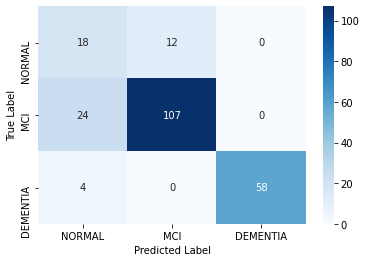

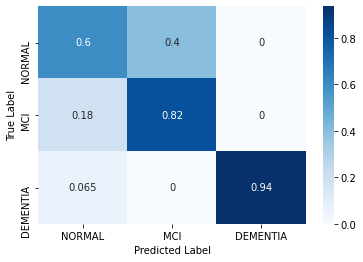

In [ ]:
print('Accuracy score: ' + str(accuracy_score(y_3, y_finale)))
labels = ['NORMAL', 'MCI', 'DEMENTIA']
heatmap(confusion_matrix(y_3, y_finale), annot=True, fmt= 'd', cmap=plt.cm.Blues, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
heatmap(confusion_matrix(y_3, y_finale, normalize='true'), annot=True, cmap=plt.cm.Blues, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()